Deep Learning
=============

The goal of this assignment is to train a Word2Vec skip-gram model over enron data set

In [71]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
#Reference udacity, http://amunategui.github.io/office-automation-part3/index.html
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import collections
import os
import random
import numpy as np
from tqdm import tqdm
import sys, email
import pandas as pd 
import math
import datetime

import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Load file email.csv

In [72]:
import sys
import csv
maxInt = sys.maxsize

csv.field_size_limit(2223370)
    

2223370

In [73]:
ENRON_EMAIL_DATASET_PATH = 'emails.csv'

# load enron dataset
import pandas as pd 
emails_df = pd.read_csv(ENRON_EMAIL_DATASET_PATH, engine = 'python', nrows = 426300)
print(emails_df.shape)
emails_df.head()


(426300, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


Read the data into a string.

In [74]:
# Sort out required email features: date, subject, content
# source https://www.kaggle.com/zichen/explore-enron
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

import email
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['Content'] = list(map(get_text_from_email, messages))

# keep only Subject and Content for this exercise
emails_df = emails_df[['Date','Subject','Content']]

In [75]:
emails_df.head()

,Date,Subject,Content
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,Here is our forecast\n\n
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,Traveling to have a business meeting takes the...
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,test successful. way to go!!!
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",,"Randy,\n\n Can you send me a schedule of the s..."
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",Re: Hello,Let's shoot for Tuesday at 11:45.


In [76]:
# change model to work with Enron emails
# point it to our Enron data set
emails_sample_df = emails_df.copy()

import string, re
# clean up subject line
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.lower()
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.replace(r'[^a-z]', ' ')  
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.replace(r'\s+', ' ')  

# clean up content line
emails_sample_df['Content'] = emails_sample_df['Content'].str.lower()
emails_sample_df['Content'] = emails_sample_df['Content'].str.replace(r'[^a-z]', ' ')  
emails_sample_df['Content'] = emails_sample_df['Content'].str.replace(r'\s+', ' ')  

# create sentence list 
emails_text = (emails_sample_df["Subject"] + " " + emails_sample_df["Content"]).tolist()

sentences = ' '.join(emails_text)
words = sentences.split()

print('Data size', len(words))
 

# get unique words and map to glove set
print('Unique word count', len(set(words))) 
 

Data size 119774160
Unique word count 538420


Build the dictionary and replace rare words with UNK token.

In [77]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 2127486], ('the', 4774746), ('to', 3381123), ('and', 2167959), ('of', 2009486)]
Sample data [142, 11, 54, 2031, 41, 4178, 2, 25, 5, 105]


In [78]:
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Sample data [142, 11, 54, 2031, 41, 4178, 2, 25, 5, 105] ['here', 'is', 'our', 'forecast', 're', 'traveling', 'to', 'have', 'a', 'business']


Function to generate a training batch for the skip-gram model.

In [79]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['here', 'is', 'our', 'forecast', 're', 'traveling', 'to', 'have']

with num_skips = 2 and skip_window = 1:
    batch: ['is', 'is', 'our', 'our', 'forecast', 'forecast', 're', 're']
    labels: ['our', 'here', 'forecast', 'is', 'our', 're', 'traveling', 'forecast']

with num_skips = 4 and skip_window = 2:
    batch: ['our', 'our', 'our', 'our', 'forecast', 'forecast', 'forecast', 'forecast']
    labels: ['re', 'is', 'forecast', 'here', 're', 'is', 'our', 'traveling']


Train a skip-gram model.

In [80]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [81]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.060779
Nearest to may: rain, prorating, gso, reggie, unambiguously, starnes, incredibly, rocket,
Nearest to of: customization, autex, technologically, cumbersome, gillis, gym, telluride, qualitec,
Nearest to was: thank, nuptials, adver, mcandrew, damper, tile, voters, lehrer,
Nearest to have: kruscit, hafslund, intervenor, ashburn, swim, userreference, startchk, marta,
Nearest to is: inconvenience, fitrx, azure, warri, stumbling, esmeralda, direcpc, pl,
Nearest to will: adx, exploratory, napm, graces, typographical, diagnostics, revolt, screen,
Nearest to me: msmail, operating, transcoastal, dldorrell, van, payton, marketinfo, repond,
Nearest to they: unfulfilled, ubspainewebber, hastings, glaser, talisman, caring, hu, iea,
Nearest to ees: utilised, economic, shel, jgaa, jmunoz, katrin, guessed, govern,
Nearest to also: damage, operationally, edb, justifiable, ocean, feature, nuff, luncheon,
Nearest to UNK: cushnie, bedding, bernardino, inancial, b

Average loss at step 52000: 1.332281
Average loss at step 54000: 1.796912
Average loss at step 56000: 2.361950
Average loss at step 58000: 2.547576
Average loss at step 60000: 2.503150
Nearest to may: should, will, might, could, would, can, ll, does,
Nearest to of: embarrassing, eex, ante, reorder, reques, kdecell, competitive, for,
Nearest to was: is, were, has, criminal, nca, zach, ecare, vlans,
Nearest to have: had, ve, need, has, be, get, want, niagra,
Nearest to is: was, s, remains, has, does, upholding, logxxxx, flaniganlaw,
Nearest to will: should, may, could, would, ll, might, can, must,
Nearest to me: us, him, nca, them, embracing, kong, hayden, you,
Nearest to they: we, you, i, he, ronnie, expire, palczer, wodka,
Nearest to ees: ect, peripheral, ndm, sisters, jmunoz, chri, islander, ramped,
Nearest to also: which, still, that, telxon, who, ieee, adversaries, never,
Nearest to UNK: regards, fm, bonnard, issuealert, economically, clcs, h, lavinia,
Nearest to company: crisis, pr

In [82]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

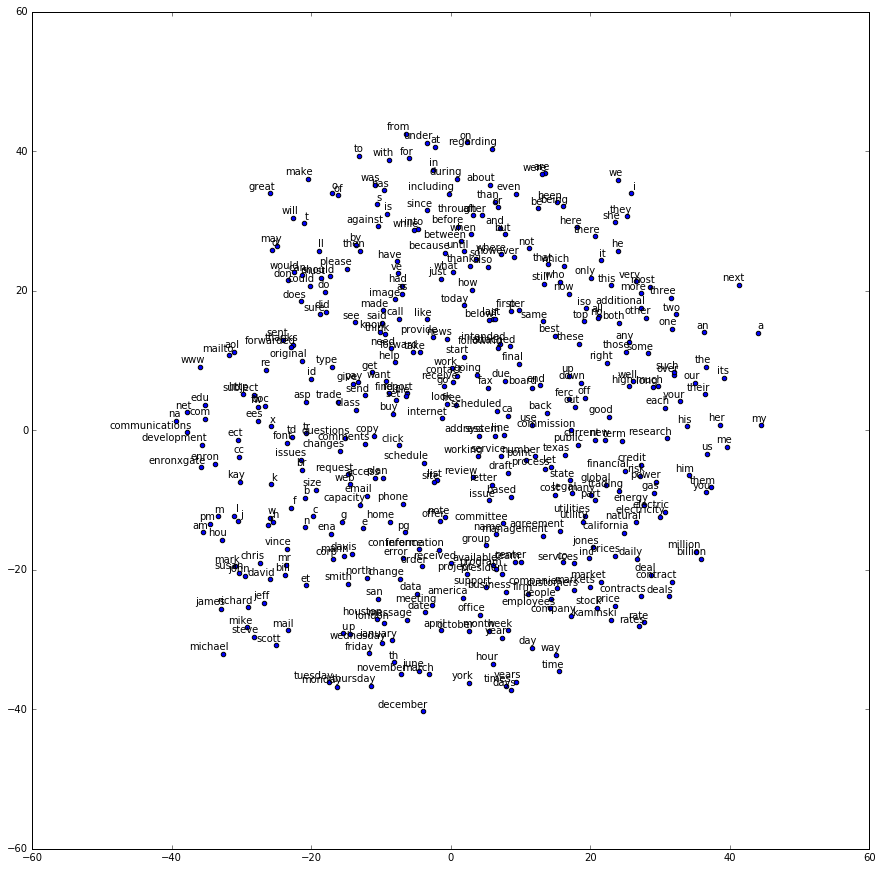

In [83]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---